In [12]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

Rough talking notes:

- How do computers understand language?
    - Embedding language as a vector space 
    - "You shall know a word by the company it keeps" (John Rupert Firth)
    - Interpreting semantics as geometry
    - Matrices as transformations on language
    - Actually training a model

- What can we do with that understanding?
    - Maths on languages! (answering analogy problems)
    - Simple classification tasks (think sentiment analysis)
    - A more compelling example: "Exploiting Similarities among Languages for Machine Translation."

- Some mathematical caveats:
    - Machine Learning is no stranger to the [replication crisis](https://www.technologyreview.com/2020/11/12/1011944/artificial-intelligence-replication-crisis-science-big-tech-google-deepmind-facebook-openai/).
    - Some problems are the result of a lack of transparency from large companies publishing results (FAANG).
    - But others are because we lack the tools (Mathematical, statistical tools) to quantify how robust our results are.
        - Will the algorithms we use converge in the kinds of environments we use them in
        - Is the convergence stable? (Often it isn't).
        - Many problems we apply our algorithms to are ill-conditioned and ill-posed, but much of the theory comes from fields like convex optimisation (where things are typically well-posed and are not ill-conditioned).
    - Contemporary mathematical work has focussed on the theoretical underpinning for *why* the things we do in ML work.
        - See [here](https://www.quantamagazine.org/computer-scientists-prove-why-bigger-neural-networks-do-better-20220210/) (notice how fundamental this question is, it's an indication of just how behind the theory is).

# How do Computers Understand Language?

A *natural language* is the kind of languages you and I speak. They do not have a formal set of rules (in contrast to *formal languages* like Python). There is a vast amount of information expressed in natural language, and we would like to be able to analyse that information using a computer. The field of Computer Science dedicated to finding ways of analysing natural languages using computers is known as Natural Language Processing (NLP for short).


In the beginning, we processed natural language with hand-designed rules and representations. Over time, we have gradually moved to statistical techniques to analyse languages, and this spawned an entire offshoot of interesting techniques (for the inclined, have a Google around for terms like "n-gram models" and "Kneser smoothing").
More recently, we have learned how to teach a computer to think about language geometrically. This has revolutionised the way we model language, and I'd like to share the key insights that go into this.


The fundamental idea is simple. We first take a sentence and break it up into words. When we do this we typically discard the punctuation and capitalization information as an approximation that often improves our results. There are packages that do the very difficult job of preprocessing text for NLP purposes automatically.

In [2]:
sentence = 'the quick brown fox jumps over the lazy dog'
words = sentence.split()
print(words) # it's what you'd expect.

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


Typically, we do this to a number of sentences that collectively make up a *corpus*. A corpus usually draws text from one topic relating to the problem you're trying to solve. If you were trying to assign positive or negative labels to hotel reviews (a *classification problem*), the topic would be hotel reviews and the corpus would consist of all of these reviews. We'll stick to a very small corpus for illustrative purposes.

In [4]:
corpus = [
    "the quick brown fox jumps over the lazy dog",
    "mathematics is the best subject",
    "my favourite numbers are primes", 
    "the dog plays like a puppy"
]

words = [sentence.split() for sentence in corpus]
print(words)

[['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog'], ['mathematics', 'is', 'the', 'best', 'subject'], ['my', 'favourite', 'numbers', 'are', 'primes'], ['the', 'dog', 'plays', 'like', 'a', 'puppy']]


The computer then assigns vectors to each word that it encounters in the corpus. The set of words in a corpus is known as a vocabulary. How do we assign the vectors? Good question, we'll address that in a second. For now we'll randomly assign each word a two-dimensional vector.

{'a': array([0.35952734, 0.23765189]), 'the': array([0.13221844, 0.02371689]), 'mathematics': array([0.42150703, 0.10254666]), 'favourite': array([0.87609084, 0.96066949]), 'puppy': array([0.3357428 , 0.39070672]), 'like': array([0.8076024 , 0.16683388]), 'jumps': array([0.30621779, 0.63453922]), 'over': array([0.53036125, 0.66478021]), 'is': array([0.54860384, 0.49584394]), 'brown': array([0.25843348, 0.34608877]), 'numbers': array([0.85121129, 0.0157579 ]), 'dog': array([0.02333143, 0.07434126]), 'fox': array([0.91744263, 0.29256046]), 'best': array([0.1062328 , 0.08211724]), 'my': array([0.78725285, 0.65995388]), 'are': array([0.53061142, 0.18935348]), 'lazy': array([0.71450627, 0.90034394]), 'quick': array([0.40052727, 0.32511488]), 'subject': array([0.58783013, 0.85126365]), 'primes': array([0.82531594, 0.54735722]), 'plays': array([0.02806814, 0.01672575])}


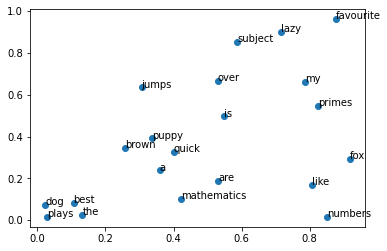

In [17]:
vocabulary = set(itertools.chain(*words)) # Quick hack to build a vocabulary
dictionary = {word: np.random.rand(2) for word in list(vocabulary)}
print(dictionary)
# Let's plot these words to get a sense of where they are in relation to one another.
points = np.array(list(dictionary.values()))
plt.scatter(points[:, 0], points[:, 1])
for word, point in dictionary.items():
    plt.annotate(word, tuple(point))
plt.show()

An *embedding* is an assignment of the words in the vocabulary to vectors. What we have just done is made a terrible embedding. A computer will learn nothing from this embedding because the embedding doesn't represent any information at all -- it's random. What makes a good embedding? We hereby present the Fundamental Principle of Natural Language Processing:

> A good embedding is one where proximity between vectors (as measured with the dot product) implies proximity in the semantic meaning of the associated words.

That is to say, "puppy" and "dog" should be close together in the above diagram because they are very similar words. Likewise, "numbers", "primes" and "mathematics" should be close together. Semantic meaning could represent a lot of different things depending on the domain you're working in and the problem you're solving. 

Because semantic meaning is complicated, embeddings are typically high dimensional (think 300 dimensions at least).


## Training an Embedding

The following quote by linguist John Rupert Firth no joke summarised the entire operating principle of NLP until very recently:

> You shall know a word by the company it keeps.

Firth's key insight is that related words co-occur. The words "mathematics" and "numbers" are used together a lot in papers, so the conclusion we draw is that maths has something to do with these "number" things whatever they are. Later you might start to see "number" used in context with a lot of quantifiers, such as "the number of seals on the island was estimated at over 9000", and you may infer that mathematics is related to quantities of things in the world. This is of course a gross (and wrong!) simplification of mathematics generally, but the idea is that with a big enough dataset these second and third order relations can be understood by co-occurence. This idea is known as the *distributional hypothesis*. A corollary to the distributional hypothesis and what we understand of embeddings is the following,

> A good embedding is one where co-occuring words are close (as measure with the dot product) in the embedding.

Mathematically we formalise this as an optimisation problem. Given a vocabulary $V = \left\{W_1, W_2, \ldots, W_n\right\}$ of words $W_i$, and a family (corpus) of sentences $C = \left\{S_1, S_2, \ldots, S_m\right\}$ we iterate over each sentence in the corpus to train our \(n \times d\) *embedding matrix* \(W\). Row \(i\) of the matrix \(W\) is the embedding for the word \(W_i\), and \(d\) is a parameter for how many dimensions (usually, \(d \approx 300\) or more).